# Predicting location of hyperbolas Instance Segmentation

In this Notebook we dive in on how to interact with the Yolo Model and extract the bounding boxes out of predictions. the Notebook is divided into following chapters

- Chapter 1: Load Yolo Model
- Chapter 2: Predicting Locations of Hyperbolas with YOLO Model
- Chapter 3: Extracting Bounding Boxes and Polygons
- Chapter 4: Implementation in Pipeline



### Chapter 1: Load Yolo Model

First we load a Yolo Model we can do this directly threw the **ultralytics** Library.

In [1]:
#import libraries
import numpy as np
from ultralytics import YOLO

#Setting Working directory
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

#Import the config file so that only the Filename needs to be changed in the _read_segy function
from config import *




In [2]:
#Load trained Model for Object Detection
model = YOLO(YOLO_MODEL_SEG_DIR)


We lode the Datatoolkit and create some test images

In [7]:
from Pipeline.Datatoolkit import DatatoolKit

dk1 = DatatoolKit(TEST_FILE_DIR , "EG-3D QUER001.SGY")
dk2 = DatatoolKit(TEST_FILE_DIR , "UG3DQUERUNTERZUG.SGY")
file1 = dk1.LoadSGY()
file2 = dk2.LoadSGY()
df1 = dk1.create_df(file1)
df2 = dk2.create_df(file2)

In [8]:
dk1.create_random_test_images(df=df1,file=file1,outdir=TEST_PIC_DIR,test_inline_random=True,number_random_inlines=2)

dk2.create_random_test_images(df=df2,file=file2,outdir=TEST_PIC_DIR,test_inline_random=True,number_random_inlines=2)

saved 2 images to c:\vscode\PAINDGPR\Data\Testdata\pictures
saved 2 images to c:\vscode\PAINDGPR\Data\Testdata\pictures


## Chapter 2: Predicting Locations of Hyperbolas with YOLO Model

In [11]:
results = model.predict(TEST_PIC_DIR,save =True, conf=0.4)


image 1/5 c:\vscode\PAINDGPR\Data\Testdata\pictures\EG-3D QUER001.SGY_inline_40.png: 128x640 4 hyperbolas, 77.7ms
image 2/5 c:\vscode\PAINDGPR\Data\Testdata\pictures\EG-3D QUER001.SGY_inline_59.png: 128x640 3 hyperbolas, 56.0ms
image 3/5 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_18.png: 384x640 17 hyperbolas, 103.2ms
image 4/5 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_32.png: 384x640 15 hyperbolas, 114.6ms
image 5/5 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_4.png: 384x640 14 hyperbolas, 120.5ms
Speed: 2.0ms preprocess, 94.4ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\vscode\PAINDGPR\Notebooks\runs\segment\predict3


here is a Prediction of the Segmentation Model.
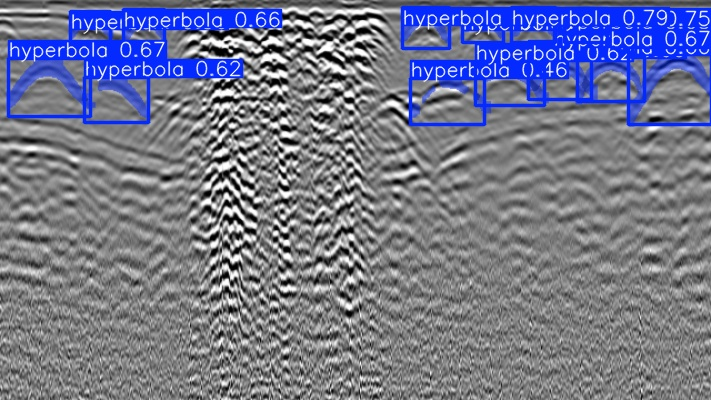

## Chapter 3: Extracting Bounding Boxes and Polygons

We take the function which was created in **4 Predicting_location_of_hyperbolas_Object_Detection.ipynb** and adjust it so we can extract the polygons.

In [16]:
import os
import numpy as np

def extract_boxes_and_polygons(results)-> dict:
    all_results = {}

    for result in results:
        img_name = os.path.basename(result.path)
        data = {}
        if result.boxes is not None:
            data["boxes"] = result.boxes.xyxy.cpu().numpy()
            data["conf"] = result.boxes.conf.cpu().numpy()
            
        else:
            data["boxes"] = np.empty((0,4)) 
            data["conf"] = np.empty((0,))      
        
        if hasattr(result, "masks") and result.masks is not None:
            print("found polys")
            polygons = [mask.xy[0].tolist() for mask in result.masks]
            data["polygons"] = polygons
            
        
        else:
            data["polygons"] = []

        all_results[img_name] = data
    return all_results

In [ ]:
preds = extract_boxes_and_polygons(results)
print(preds)

found polys
found polys
found polys
found polys
found polys


### Chapter 4: Implementation in Pipeline

We can now implement the **ectract_boxes_and_polygons()** which is a update to the **extract_boxes()** to the **Predictor Class**. Now we can make Predictions on diffrent Model types and extract the relevant information for the type of model. Here the two types which where tested are **Object Detection** and **Instance Segmentation**